<a href="https://colab.research.google.com/github/primroseisaseal/Cryptocurrencies-forecast/blob/main/Code_1st_draft_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 336 kB/s 
     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
pip install pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Multivariate LSTM 5 Open Close High low volumn 

In [45]:
# yf.pdr_override()
# BTC = pdr.get_data_yahoo('BTC' , start="2019-01-01", end="2022-06-15" )
# BTC = BTC.reset_index()

# BTC_1 = BTC.drop(['Volume', 'Adj Close'], axis = 1)
url = 'https://raw.githubusercontent.com/primroseisaseal/Cryptocurrencies-forecast/main/feature_1.csv'
BTC_1 = pd.read_csv(url)
BTC_1 = BTC_1.iloc[:,1:5]

BTC_1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    366 non-null    float64
 1   High    366 non-null    float64
 2   Low     366 non-null    float64
 3   Close   366 non-null    float64
dtypes: float64(4)
memory usage: 11.6 KB


In [46]:
# Split train test with 65% train
train_size = int(len(BTC_1)*0.65)
BTC_train = BTC_1.iloc[:train_size,1:]

BTC_test = BTC_1.iloc[train_size:,1:]
BTC_test['Close']=BTC_test['Close'].astype('float64')

# For Training Set, split into X (Open, High, low, CLose) and y (Close) then scale it
sc = MinMaxScaler(feature_range=(0,1))
data_train_scaled = sc.fit_transform(BTC_train)

sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(BTC_train[['Close']])

# create 3D df for LSTM
hop = 2
X_train = []
y_train = []
for i in range(hop, train_size):
  X_train.append(data_train_scaled[i-hop:i])
  y_train.append(y_train_scaled[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))

#fit trian df into the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)





Epoch 1/100
8/8 [==============================] - 8s 11ms/step - loss: 0.3856
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 0.3054
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1771
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0482
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0511
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0317
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0306
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0254
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 10/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0201
Epoch 11/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0182
Epoch 12/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 13/100
8/8 [==============================]

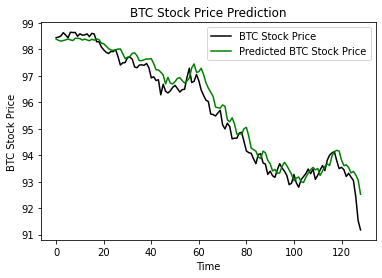

In [47]:
# Prepaering for test data set
train_lasthopdays = BTC_train.iloc[-hop:]
full_df = pd.concat((train_lasthopdays,BTC_test), axis =0)
full_df

full_df_scaled = sc.fit_transform(full_df)
full_df_scaled.shape

X_test = []

for i in range(hop, len(full_df_scaled)):
  X_test.append(full_df_scaled[i-hop:i])

X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
X_test.shape

full_df_scaled = pd.DataFrame(full_df_scaled)
full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1]

y_pred = model.predict(X_test)
len(y_pred)


y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.rename(columns = {0 :'Close_pred'})

full_df_scaled = pd.DataFrame(full_df_scaled)
toinv_full = full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1].reset_index()
toinv_full = toinv_full.iloc[:,1:]
# toinv_full = toinv_full.rename(columns = list(BTC_2))
toinv_full
# print(y_pred)


to_inv = pd.concat((toinv_full,y_pred), axis = 1)
to_inv

y_final_pred = sc.inverse_transform(to_inv)
y_final_pred = pd.DataFrame(y_final_pred)
# y_final_pred = y_final_pred.rename(columns = {0 :'Open', 1: 'High', 2:'low', 3:'Close_pred'})
y_final_pred

full_final_df = pd.concat((BTC_test.reset_index(), y_final_pred.iloc[:,-1:]), axis =1)
full_final_df

plt.plot(full_final_df['Close'], color = 'black', label = 'BTC Stock Price')
plt.plot(full_final_df.iloc[:,-1:], color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [40]:
Close_pred = full_final_df.iloc[:,-1:].values
Close_actual = full_final_df['Close'].values
print(f'test RSME: {math.sqrt(mean_squared_error(Close_actual,Close_pred))}')

test RSME: 0.4027820063841196


# Multivariate LSTM 31 features from 

Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [48]:
# import data set which I calculate 30 features from other .ipynb file 
url = 'https://raw.githubusercontent.com/primroseisaseal/Cryptocurrencies-forecast/main/feature_18.csv'
BTC_2 = pd.read_csv(url)
BTC_2 = BTC_2.drop('Date', axis =1)
BTC_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   OpenRSI                  366 non-null    float64
 1   OpenSMA3                 366 non-null    float64
 2   Diff_OpenSMA3            366 non-null    float64
 3   OpenEMA5                 366 non-null    float64
 4   Diff_OpenEMA5            366 non-null    float64
 5   Movement_OpenEMA5        366 non-null    float64
 6   Diff_Close               366 non-null    float64
 7   Movement_Close           366 non-null    float64
 8   CloseRSI                 366 non-null    float64
 9   Diff_CloseRSI            366 non-null    float64
 10  Movement_closeRSI        366 non-null    float64
 11  CloseEMA5                366 non-null    float64
 12  Diff_CloseEMA5           366 non-null    float64
 13  Movement_Diff_CloseEMA5  366 non-null    float64
 14  CloseSMA3                3

In [49]:

# Split train test with 65% train
train_size = int(len(BTC)*0.65)
BTC_train = BTC_2.iloc[:train_size,1:]

BTC_test = BTC_2.iloc[train_size:,1:]
BTC_test['Close']=BTC_test['Close'].astype('float64')

# For Training Set, split into X (Open, High, low, CLose) and y (Close) then scale it
sc = MinMaxScaler(feature_range=(0,1))
data_train_scaled = sc.fit_transform(BTC_train)

sc2 = MinMaxScaler(feature_range=(0,1))
y_train_scaled = sc2.fit_transform(BTC_train[['Close']])

# create 3D df for LSTM
hop = 2
X_train = []
y_train = []
for i in range(hop, train_size):
  X_train.append(data_train_scaled[i-hop:i])
  y_train.append(y_train_scaled[i][0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],  X_train.shape[2]))

#fit trian df into the model
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
9/9 [==============================] - 10s 18ms/step - loss: 0.4790
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 0.3369
Epoch 3/100
9/9 [==============================] - 0s 11ms/step - loss: 0.0976
Epoch 4/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0577
Epoch 5/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0412
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 0.0348
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0312
Epoch 8/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0245
Epoch 9/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0226
Epoch 10/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0158
Epoch 11/100
9/9 [==============================] - 0s 31ms/step - loss: 0.0151
Epoch 12/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0134
Epoch 13/100
9/9 [==============================

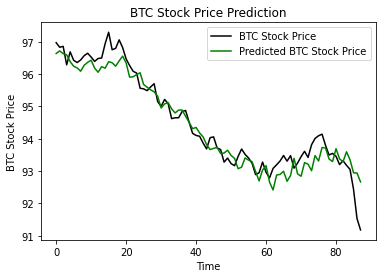

In [50]:
# Prepaering for test data set
train_lasthopdays = BTC_train.iloc[-hop:]
full_df = pd.concat((train_lasthopdays,BTC_test), axis =0)
full_df

full_df_scaled = sc.fit_transform(full_df)
full_df_scaled.shape

X_test = []

for i in range(hop, len(full_df_scaled)):
  X_test.append(full_df_scaled[i-hop:i])

X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],  X_test.shape[2]))
X_test.shape

full_df_scaled = pd.DataFrame(full_df_scaled)
full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1]

y_pred = model.predict(X_test)
len(y_pred)


y_pred = pd.DataFrame(y_pred)
y_pred = y_pred.rename(columns = {0 :'Close_pred'})

full_df_scaled = pd.DataFrame(full_df_scaled)
toinv_full = full_df_scaled.iloc[hop:,0:full_df_scaled.shape[1]-1].reset_index()
toinv_full = toinv_full.iloc[:,1:]
# toinv_full = toinv_full.rename(columns = list(BTC_2))
toinv_full
# print(y_pred)


to_inv = pd.concat((toinv_full,y_pred), axis = 1)
to_inv

y_final_pred = sc.inverse_transform(to_inv)
y_final_pred = pd.DataFrame(y_final_pred)
# y_final_pred = y_final_pred.rename(columns = {0 :'Open', 1: 'High', 2:'low', 3:'Close_pred'})
y_final_pred

full_final_df = pd.concat((BTC_test.reset_index(), y_final_pred.iloc[:,-1:]), axis =1)
full_final_df

plt.plot(full_final_df['Close'], color = 'black', label = 'BTC Stock Price')
plt.plot(full_final_df.iloc[:,-1:], color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

In [51]:
Close_pred = full_final_df.iloc[:,-1:].values
Close_actual = full_final_df['Close'].values
print(f'test RSME: {math.sqrt(mean_squared_error(Close_actual,Close_pred))}')

test RSME: 0.40650133344698886


# SVR for time series forecasting
https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

In [52]:
# Prepare Data
BTC_svm = BTC_1
BTC_svm.describe()

,Open,High,Low,Close
count,366.000000,366.000000,366.000000,366.000000
mean,98.045280,98.062180,98.021062,98.039106
std,2.186498,2.181728,2.186496,2.183975
min,91.178398,91.178398,91.178398,91.178398
25%,97.351875,97.393000,97.318123,97.354626
50%,98.767498,98.772499,98.751598,98.757851
75%,99.683998,99.693750,99.664927,99.665001
max,100.889999,100.889999,100.154999,100.154999


In [53]:


#Create dataframe for SVR

df_lagged = BTC_svm.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged

#split training and testing 65% /35%
training_svr = df_lagged.iloc[:train_size,:]
X_train_svr = training_svr.drop('Close',axis =1)
y_train_svr = training_svr['Close']

testing_svr = df_lagged.iloc[train_size:,:]
X_test_svr = testing_svr.drop('Close',axis =1)
y_test_svr = testing_svr['Close']

training_svr.shape, testing_svr.shape

#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1))
training_svr_scaled = sc_df.fit_transform(training_svr)
training_svr_scaled = pd.DataFrame(training_svr_scaled,columns=training_svr.columns.values.tolist())
X_train_svr_scaled = training_svr_scaled.drop('Close',axis =1)


testing_svr_scaled = sc_df.transform(testing_svr)
testing_svr_scaled = pd.DataFrame(testing_svr_scaled,columns=testing_svr.columns.values.tolist())
X_test_svr_scaled = testing_svr_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_svr_scaled = sc_y.transform(np.array(y_train_svr).reshape(-1,1))


#fit svr model into traning set
svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr.fit(X_train_svr_scaled,y_train_svr_scaled)
y_train_svr_pred = svr.predict(X_train_svr_scaled)
y_train_svr_pred

# predict testing set
y_test_svr_pred = svr.predict(X_test_svr_scaled)
y_test_svr_pred = y_test_svr_pred.reshape(-1,1)


y_test_vr_pred_inv = sc_y.inverse_transform(y_test_svr_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_svr,y_test_vr_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 4.096213117957674


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


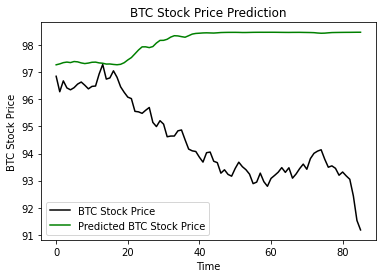

In [54]:
plt.plot(y_test_svr.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_vr_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

# SVR for time series forecasting with 31 Features from:


Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [56]:
# Prepare Data
BTC_svm_2 = BTC_2

BTC_svm_2

,OpenRSI,OpenSMA3,Diff_OpenSMA3,OpenEMA5,Diff_OpenEMA5,Movement_OpenEMA5,Diff_Close,Movement_Close,CloseRSI,Diff_CloseRSI,...,Gold_CloseRSI,usdeur_Open,usdeur_Adj_Close,usdeur_Diff_OpenSMA3,oil_Volume,oil_Diff_OpenSMA3,usdcny_Open,usdcny_High,usdcny_Close,Close
0,0.0,100.013334,0.003334,100.010000,8.477105e-07,1.0,0.034996,1.0,100.0,100.0,...,0.0,0.84830,0.848000,-0.001557,400531,1.449997,6.7898,6.7900,6.7898,100.029999
1,0.0,99.996666,-0.016668,99.989999,-2.000116e-02,-1.0,-0.110001,-1.0,0.0,-100.0,...,0.0,0.85198,0.851960,0.000163,433065,-0.719997,6.7898,6.7900,6.7898,99.919998
2,100.0,99.983332,-0.013334,99.989999,-4.709503e-07,-1.0,0.075005,1.0,100.0,100.0,...,100.0,0.84994,0.849800,-0.001053,409787,1.239998,6.7897,6.7898,6.7897,99.995003
3,0.0,99.969999,-0.013334,99.983333,-6.665862e-03,-1.0,-0.055000,-1.0,0.0,-100.0,...,100.0,0.84983,0.849834,0.000510,331703,-0.590000,6.7892,6.7897,6.7892,99.940002
4,100.0,99.979665,0.010000,99.984468,7.765971e-03,1.0,0.010002,1.0,100.0,0.0,...,100.0,0.85150,0.851630,0.000557,328295,0.840000,6.7455,6.7464,6.7455,99.974998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,93.230667,-0.091665,93.338902,-8.194937e-02,-1.0,-0.142899,-1.0,0.0,-100.0,...,100.0,0.93470,0.934700,0.001520,340591,2.699997,6.6697,6.6945,6.6697,93.175003
362,0.0,93.190834,-0.039833,93.252467,-8.643477e-02,-1.0,-0.125000,-1.0,0.0,0.0,...,0.0,0.93304,0.933040,0.000243,293295,-0.599998,6.6827,6.6975,6.6827,93.050003
363,0.0,92.991534,-0.199300,93.074978,-1.774886e-01,-1.0,-0.617401,-1.0,0.0,0.0,...,100.0,0.94169,0.941690,0.002120,352906,-0.840004,6.6908,6.7163,6.6908,92.432602
364,0.0,92.523198,-0.468335,92.639984,-4.349939e-01,-1.0,-0.905602,-1.0,0.0,0.0,...,0.0,0.95329,0.953290,0.006197,372403,0.260002,6.7079,6.7582,6.7079,91.527000


In [57]:
#Create dataframe for SVR

df_lagged = BTC_svm_2.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm_2.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm_2.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
df_lagged

#split training and testing 65% /35%
training_svr = df_lagged.iloc[:train_size,:]
X_train_svr = training_svr.drop('Close',axis =1)
y_train_svr = training_svr['Close']

testing_svr = df_lagged.iloc[train_size:,:]
X_test_svr = testing_svr.drop('Close',axis =1)
y_test_svr = testing_svr['Close']

training_svr

#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1))
training_svr_scaled = sc_df.fit_transform(training_svr)
training_svr_scaled = pd.DataFrame(training_svr_scaled,columns=training_svr.columns.values.tolist())
X_train_svr_scaled = training_svr_scaled.drop('Close',axis =1)


testing_svr_scaled = sc_df.transform(testing_svr)
testing_svr_scaled = pd.DataFrame(testing_svr_scaled,columns=testing_svr.columns.values.tolist())
X_test_svr_scaled = testing_svr_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_svr_scaled = sc_y.transform(np.array(y_train_svr).reshape(-1,1))


#fit svr model into traning set
svr = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)
svr.fit(X_train_svr_scaled,y_train_svr_scaled)
y_train_svr_pred = svr.predict(X_train_svr_scaled)
y_train_svr_pred

# predict testing set
y_test_svr_pred = svr.predict(X_test_svr_scaled)
y_test_svr_pred = y_test_svr_pred.reshape(-1,1)


y_test_vr_pred_inv = sc_y.inverse_transform(y_test_svr_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_svr,y_test_vr_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 4.784345104142374


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


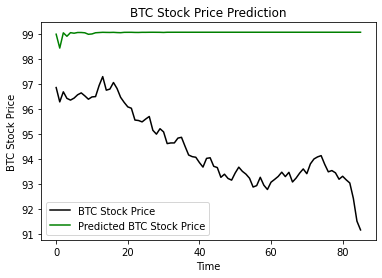

In [58]:
plt.plot(y_test_svr.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_vr_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

#XG boost

In [59]:
pip install xgboost==1.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
# xgboost
import xgboost
from xgboost import XGBRegressor
print("xgboost", xgboost.__version__)

xgboost 1.6.1


In [61]:
#Prepare df for Multivaraite timestep model
BTC_xgb = BTC_1

df_lagged = BTC_svm.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()

df_lagged

,Open,High,Low,Close,Open_lag1,High_lag1,Low_lag1,Close_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2
2,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998,100.010002,100.029999,100.010002,100.029999
3,99.970001,99.980003,99.940002,99.940002,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998
4,100.000000,100.000000,99.974998,99.974998,99.970001,99.980003,99.940002,99.940002,99.989998,99.995003,99.971703,99.995003
5,99.949997,99.959999,99.925003,99.925003,100.000000,100.000000,99.974998,99.974998,99.970001,99.980003,99.940002,99.940002
6,99.910004,99.919998,99.889999,99.889999,99.949997,99.959999,99.925003,99.925003,100.000000,100.000000,99.974998,99.974998
...,...,...,...,...,...,...,...,...,...,...,...,...
361,93.175003,93.175003,93.175003,93.175003,93.317902,93.317902,93.317902,93.317902,93.199097,93.199097,93.199097,93.199097
362,93.079597,93.079597,93.050003,93.050003,93.175003,93.175003,93.175003,93.175003,93.317902,93.317902,93.317902,93.317902
363,92.720001,92.720001,92.432602,92.432602,93.079597,93.079597,93.050003,93.050003,93.175003,93.175003,93.175003,93.175003
364,91.769997,91.769997,91.527000,91.527000,92.720001,92.720001,92.432602,92.432602,93.079597,93.079597,93.050003,93.050003


In [62]:
#split training and testing 65% /35%
training_xgb = df_lagged.iloc[:train_size,:]
X_train_xgb = training_xgb.drop('Close',axis =1)
y_train_xgb = training_xgb['Close']

testing_xgb = df_lagged.iloc[train_size:,:]
X_test_xgb = testing_xgb.drop('Close',axis =1)
y_test_xgb = testing_xgb['Close']


#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1)).fit(df_lagged)
training_xgb_scaled = sc_df.transform(training_xgb)
training_xgb_scaled = pd.DataFrame(training_xgb_scaled,columns=training_xgb.columns.values.tolist())
X_train_xgb_scaled = training_xgb_scaled.drop('Close',axis =1)


testing_xgb_scaled = sc_df.transform(testing_xgb)
testing_xgb_scaled = pd.DataFrame(testing_xgb_scaled,columns=testing_xgb.columns.values.tolist())
X_test_xgb_scaled = testing_xgb_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_xgb_scaled = sc_y.transform(np.array(y_train_xgb).reshape(-1,1))

#fit xgb model into traning set
xgb = XGBRegressor()
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train_xgb_scaled,y_train_xgb_scaled)
y_train_xgb_pred = xgb.predict(X_train_xgb_scaled)
y_train_xgb_pred

# predict testing set
y_test_xgb_pred = xgb.predict(X_test_xgb_scaled)
y_test_xgb_pred = y_test_xgb_pred.reshape(-1,1)


y_test_xgb_pred_inv = sc_y.inverse_transform(y_test_xgb_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_xgb,y_test_xgb_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv


test RSME: 2.755980031566519


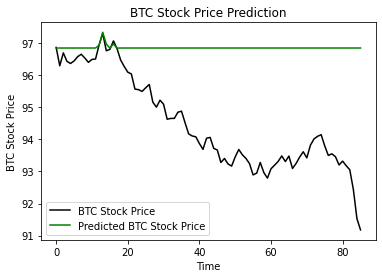

In [63]:
plt.plot(y_test_xgb.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_xgb_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()

# XGboost for time series forecasting with 31 Features from:


Dolatsara, H., Kibis, E., Caglar, M., Simsek, S., Dag, A., Dolatsara, G. and Delen, D., 2022. An interpretable decision-support systems for daily cryptocurrency trading. Expert Systems with Applications, 203, p.117409.
https://doi.org/10.1016/j.eswa.2022.117409

In [65]:
#Prepare df for Multivaraite timestep model
BTC_xgb_2 = BTC_2
df_lagged = BTC_xgb_2.copy()
trailing_window_size = hop

for window in range(1, trailing_window_size + 1):
    shifted = BTC_svm.shift(window)
    shifted.columns = [x + "_lag" + str(window) for x in BTC_svm.columns]
    
    df_lagged = pd.concat((df_lagged, shifted), axis=1)
df_lagged = df_lagged.dropna()
# df_lagged = df_lagged.drop('Date', axis =1)
df_lagged

,OpenRSI,OpenSMA3,Diff_OpenSMA3,OpenEMA5,Diff_OpenEMA5,Movement_OpenEMA5,Diff_Close,Movement_Close,CloseRSI,Diff_CloseRSI,...,usdcny_Close,Close,Open_lag1,High_lag1,Low_lag1,Close_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2
2,100.0,99.983332,-0.013334,99.989999,-4.709503e-07,-1.0,0.075005,1.0,100.0,100.0,...,6.7897,99.995003,99.949997,99.959999,99.919998,99.919998,100.010002,100.029999,100.010002,100.029999
3,0.0,99.969999,-0.013334,99.983333,-6.665862e-03,-1.0,-0.055000,-1.0,0.0,-100.0,...,6.7892,99.940002,99.989998,99.995003,99.971703,99.995003,99.949997,99.959999,99.919998,99.919998
4,100.0,99.979665,0.010000,99.984468,7.765971e-03,1.0,0.010002,1.0,100.0,0.0,...,6.7455,99.974998,99.970001,99.980003,99.940002,99.940002,99.989998,99.995003,99.971703,99.995003
5,0.0,99.983332,-0.009666,99.976429,-1.321614e-02,-1.0,-0.019997,-1.0,0.0,0.0,...,6.7239,99.925003,100.000000,100.000000,99.974998,99.974998,99.970001,99.980003,99.940002,99.940002
6,0.0,99.953334,-0.029999,99.954287,-2.214186e-02,-1.0,-0.035004,-1.0,0.0,0.0,...,6.6966,99.889999,99.949997,99.959999,99.925003,99.925003,100.000000,100.000000,99.974998,99.974998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,0.0,93.230667,-0.091665,93.338902,-8.194937e-02,-1.0,-0.142899,-1.0,0.0,-100.0,...,6.6697,93.175003,93.317902,93.317902,93.317902,93.317902,93.199097,93.199097,93.199097,93.199097
362,0.0,93.190834,-0.039833,93.252467,-8.643477e-02,-1.0,-0.125000,-1.0,0.0,0.0,...,6.6827,93.050003,93.175003,93.175003,93.175003,93.175003,93.317902,93.317902,93.317902,93.317902
363,0.0,92.991534,-0.199300,93.074978,-1.774886e-01,-1.0,-0.617401,-1.0,0.0,0.0,...,6.6908,92.432602,93.079597,93.079597,93.050003,93.050003,93.175003,93.175003,93.175003,93.175003
364,0.0,92.523198,-0.468335,92.639984,-4.349939e-01,-1.0,-0.905602,-1.0,0.0,0.0,...,6.7079,91.527000,92.720001,92.720001,92.432602,92.432602,93.079597,93.079597,93.050003,93.050003


In [66]:
#split training and testing 65% /35%
training_xgb = df_lagged.iloc[:train_size,:]
X_train_xgb = training_xgb.drop('Close',axis =1)
y_train_xgb = training_xgb['Close']

testing_xgb = df_lagged.iloc[train_size:,:]
X_test_xgb = testing_xgb.drop('Close',axis =1)
y_test_xgb = testing_xgb['Close']


#Scale data
# split into X (Open, High, low, CLose) and y (Close) then scale it
sc_df = MinMaxScaler(feature_range=(0,1)).fit(df_lagged)
training_xgb_scaled = sc_df.transform(training_xgb)
training_xgb_scaled = pd.DataFrame(training_xgb_scaled,columns=training_xgb.columns.values.tolist())
X_train_xgb_scaled = training_xgb_scaled.drop('Close',axis =1)


testing_xgb_scaled = sc_df.transform(testing_xgb)
testing_xgb_scaled = pd.DataFrame(testing_xgb_scaled,columns=testing_xgb.columns.values.tolist())
X_test_xgb_scaled = testing_xgb_scaled.drop('Close',axis =1)

#scaled y

sc_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(df_lagged['Close']).reshape(-1,1))
y_train_xgb_scaled = sc_y.transform(np.array(y_train_xgb).reshape(-1,1))

#fit xgb model into traning set
xgb = XGBRegressor()
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgb.fit(X_train_xgb_scaled,y_train_xgb_scaled)
y_train_xgb_pred = xgb.predict(X_train_xgb_scaled)
y_train_xgb_pred

# predict testing set
y_test_xgb_pred = xgb.predict(X_test_xgb_scaled)
y_test_xgb_pred = y_test_xgb_pred.reshape(-1,1)


y_test_xgb_pred_inv = sc_y.inverse_transform(y_test_xgb_pred)

print(f'test RSME: {math.sqrt(mean_squared_error(y_test_xgb,y_test_xgb_pred_inv))}')
# y_test_vr_pred_inv.tolist()
# y_test_vr_pred_inv

test RSME: 2.818970543919116


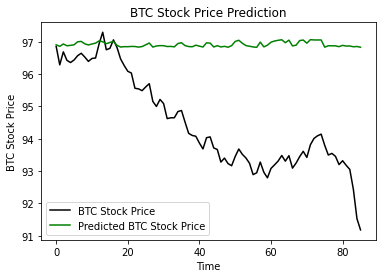

In [67]:
plt.plot(y_test_xgb.values, color = 'black', label = 'BTC Stock Price')
plt.plot(y_test_xgb_pred_inv, color = 'green', label = 'Predicted BTC Stock Price')
plt.title('BTC Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Stock Price')
plt.legend()
plt.show()